In [43]:
# === SECTION 1: Data Loading & Preprocessing ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

In [44]:
# Load dataset
df = pd.read_csv("/content/fetal_health.csv")
df.drop_duplicates(inplace=True)

In [45]:
X = df.drop(columns='fetal_health')
y = df['fetal_health']

In [46]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [47]:
# Feature Selection (Top 10 features by ANOVA F-test)
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)
selected_feature_names = X.columns[selector.get_support()].tolist()

In [48]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, stratify=y, test_size=0.2, random_state=42)

In [49]:
# Cost-sensitive class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

In [50]:
# === SECTION 2: Model Training ===
# SVM
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True)
svm_model.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True)

In [51]:
# ANN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [52]:
y_train_cat = to_categorical(y_train - 1)
y_test_cat = to_categorical(y_test - 1)

ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
ann_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
ann_model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat),
              epochs=50, batch_size=32, class_weight=class_weight_dict,
              callbacks=[early_stop], verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
# XGBoost
from xgboost import XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
yy_train = y_train - 1
yy_test = y_test - 1
yy_train = yy_train.astype(int)
yy_test = yy_test.astype(int)
xgb_model.fit(X_train, yy_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:47:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [54]:
# === SECTION 3: Evaluation ===
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

SVM Classification Report:

              precision    recall  f1-score   support

         1.0       0.99      0.89      0.94       330
         2.0       0.60      0.91      0.73        58
         3.0       0.84      0.91      0.88        35

    accuracy                           0.90       423
   macro avg       0.81      0.91      0.85       423
weighted avg       0.92      0.90      0.90       423



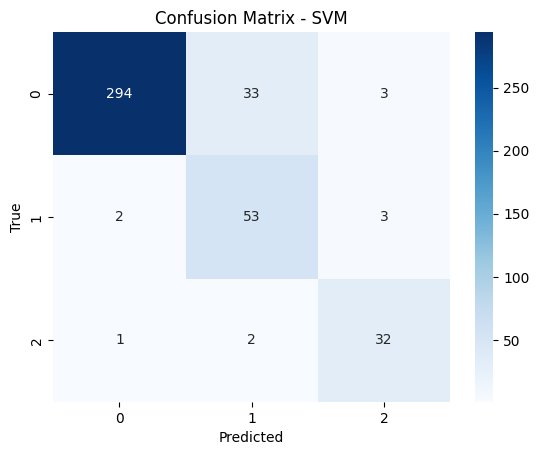


ANN Classification Report:

              precision    recall  f1-score   support

         1.0       0.90      0.98      0.94       330
         2.0       0.79      0.19      0.31        58
         3.0       0.65      0.91      0.76        35

    accuracy                           0.87       423
   macro avg       0.78      0.69      0.67       423
weighted avg       0.86      0.87      0.84       423



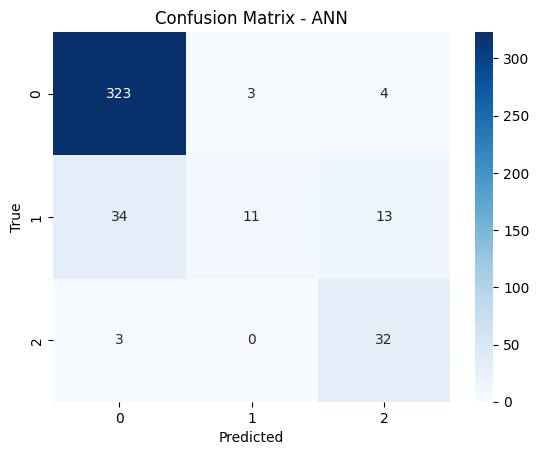


XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       330
           1       0.98      0.81      0.89        58
           2       1.00      0.94      0.97        35

    accuracy                           0.97       423
   macro avg       0.98      0.92      0.95       423
weighted avg       0.97      0.97      0.97       423



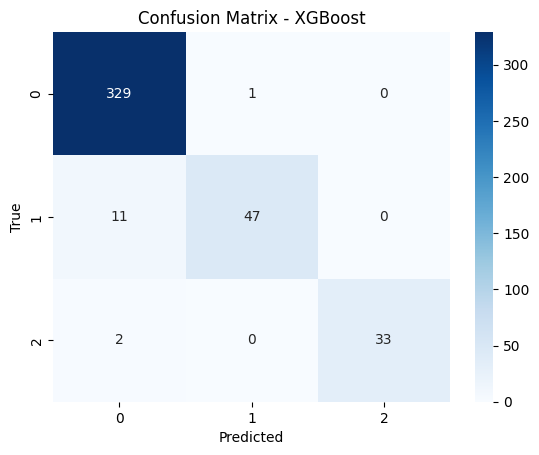

In [55]:
# Predictions
y_pred_svm = svm_model.predict(X_test)
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1) + 1
y_pred_xgb = xgb_model.predict(X_test)

evaluate_model("SVM", y_test, y_pred_svm)
evaluate_model("ANN", y_test, y_pred_ann)
evaluate_model("XGBoost", yy_test, y_pred_xgb)


SVM + SMOTE Classification Report:

              precision    recall  f1-score   support

         1.0       0.98      0.89      0.93       330
         2.0       0.59      0.88      0.70        58
         3.0       0.84      0.89      0.86        35

    accuracy                           0.89       423
   macro avg       0.80      0.89      0.83       423
weighted avg       0.92      0.89      0.90       423



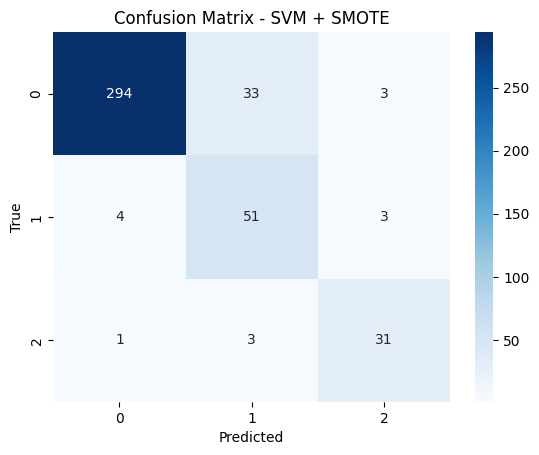

In [56]:
# === SECTION 4: SMOTE Comparison ===
X_sm, y_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)

svm_sm = SVC(kernel='rbf', probability=True)
svm_sm.fit(X_sm, y_sm)
y_pred_svm_sm = svm_sm.predict(X_test)
evaluate_model("SVM + SMOTE", y_test, y_pred_svm_sm)

In [57]:
# === SECTION 5: Hyperparameter Tuning with GridSearch ===
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 1],
    'kernel': ['rbf']
}
grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, scoring='f1_weighted', cv=3)
grid.fit(X_train, y_train)
print("\nBest Parameters from GridSearchCV:", grid.best_params_)


Best Parameters from GridSearchCV: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


<Figure size 640x480 with 0 Axes>

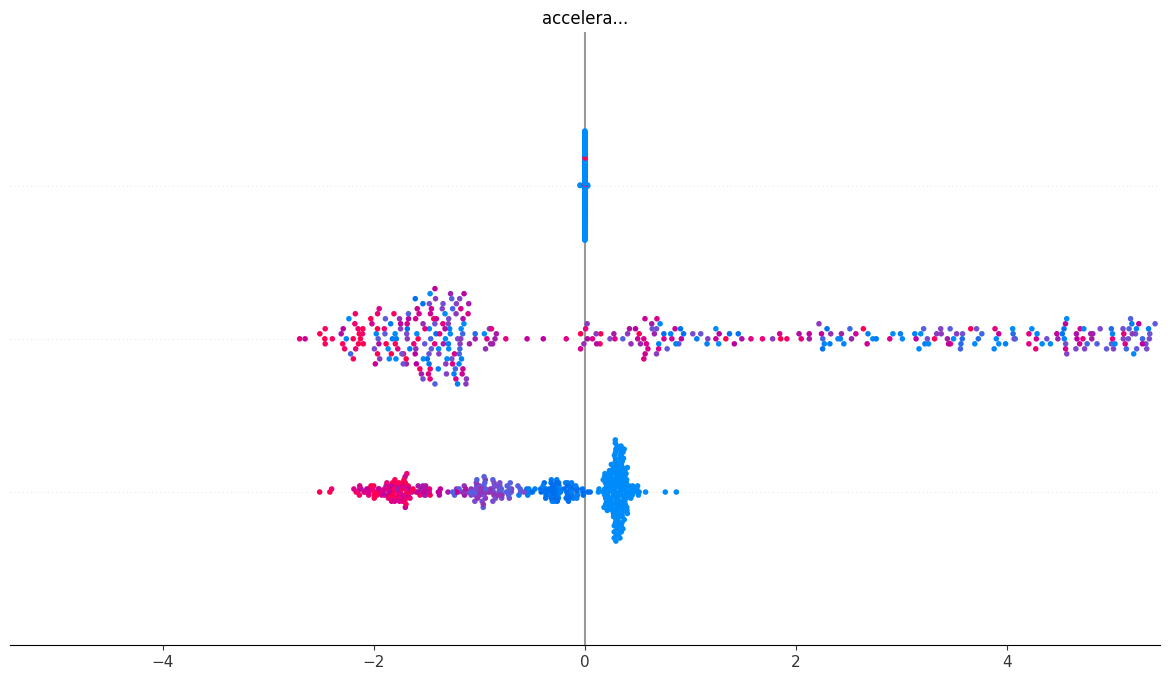

In [58]:
# === SECTION 6: SHAP Interpretation ===
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features=X_test, feature_names=selected_feature_names)

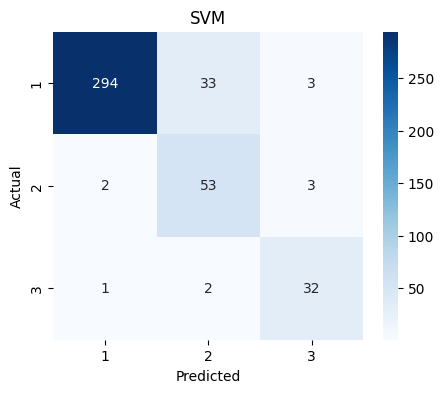

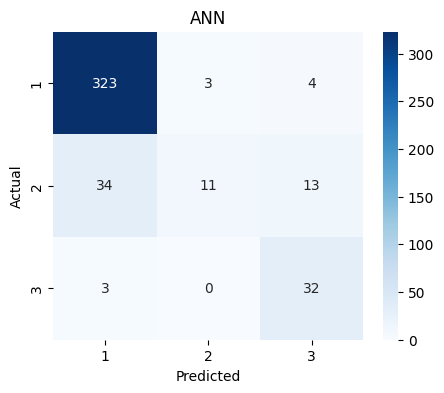

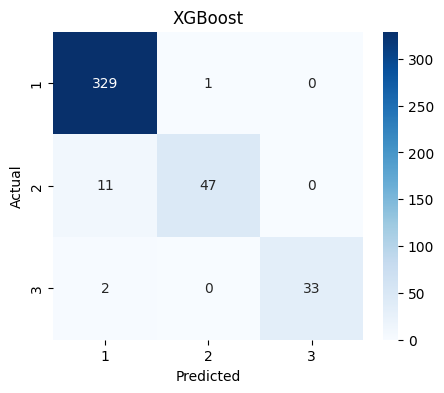

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_svm, title="SVM")
plot_confusion_matrix(y_test, y_pred_ann, title="ANN")
plot_confusion_matrix(yy_test, y_pred_xgb, title="XGBoost")


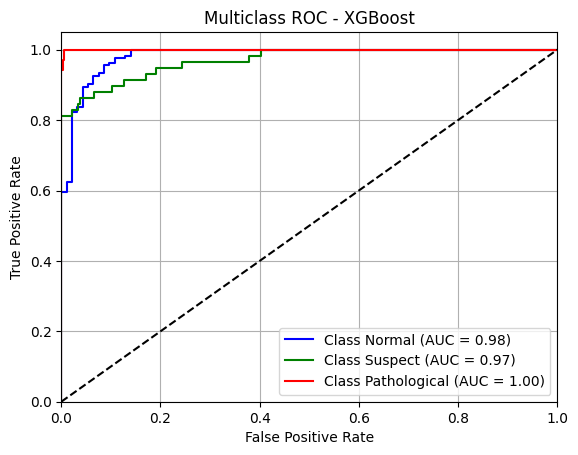

In [61]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize labels
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
y_score_xgb = xgb_model.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_xgb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['blue', 'green', 'red']
labels = ['Normal', 'Suspect', 'Pathological']
for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC - XGBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


<Figure size 640x480 with 0 Axes>

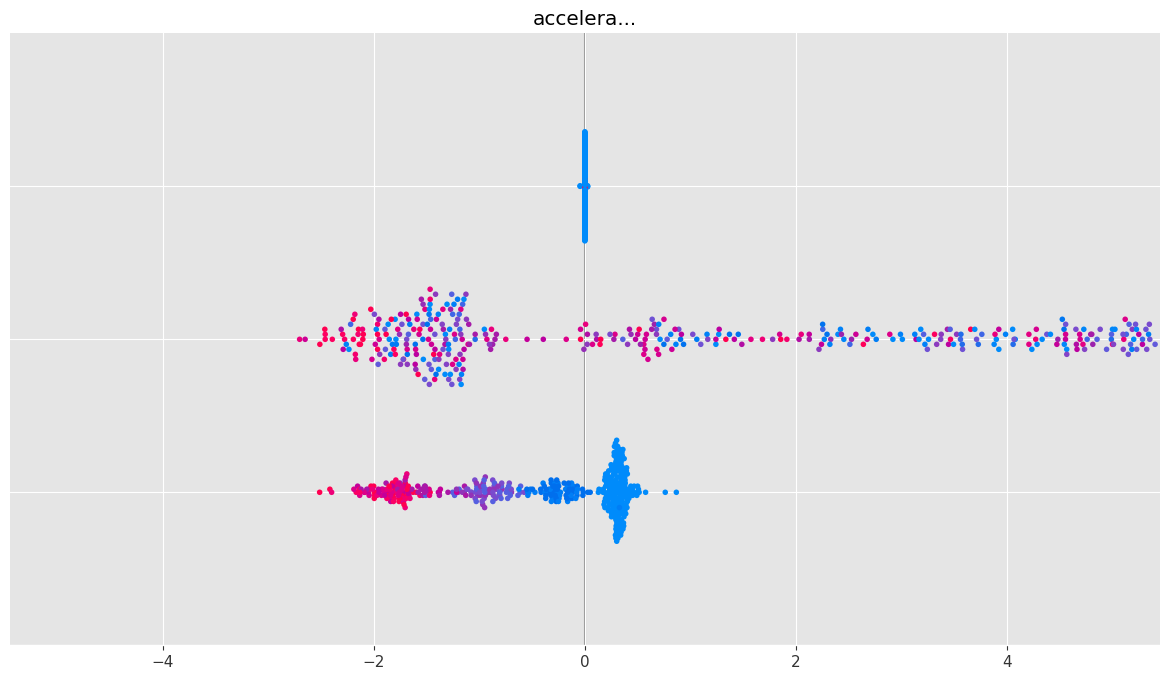

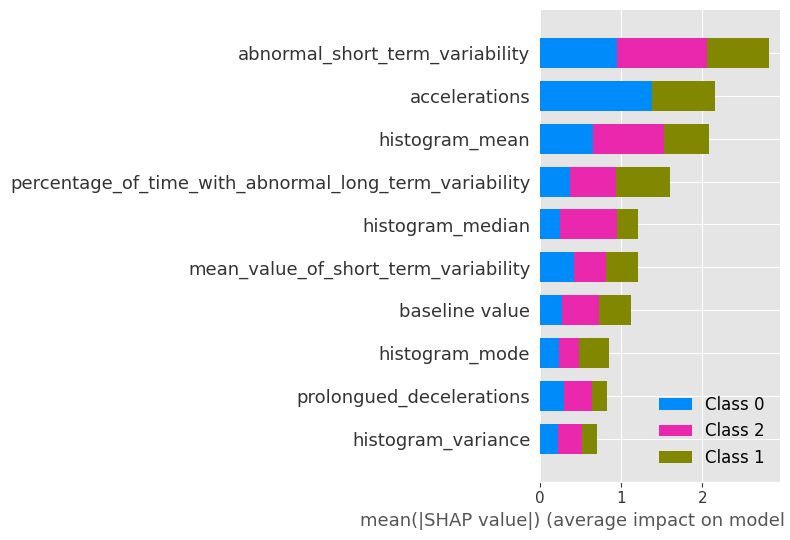

In [72]:
import shap

# Summary Plot (Global Importance)
shap.summary_plot(shap_values, X_test, feature_names=selected_feature_names)

# Bar Plot (Mean Absolute Value)
shap.summary_plot(shap_values, X_test, feature_names=selected_feature_names, plot_type='bar')

# Force plot for a specific sample
shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0], features=X_test.iloc[0], feature_names=selected_feature_names)


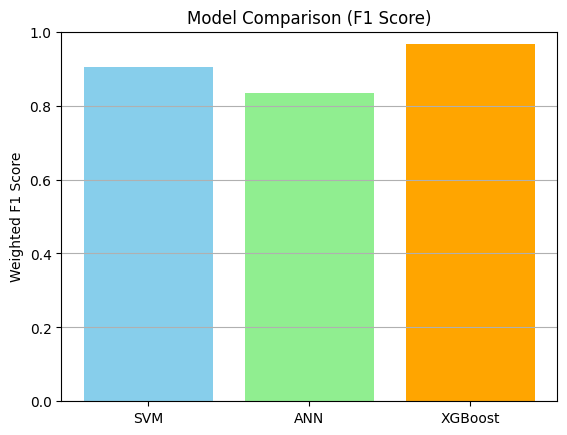

In [63]:
from sklearn.metrics import f1_score, accuracy_score

models = ['SVM', 'ANN', 'XGBoost']
scores = [
    f1_score(y_test, y_pred_svm, average='weighted'),
    f1_score(y_test, y_pred_ann, average='weighted'),
    f1_score(yy_test, y_pred_xgb, average='weighted')
]

plt.bar(models, scores, color=['skyblue', 'lightgreen', 'orange'])
plt.ylabel("Weighted F1 Score")
plt.title("Model Comparison (F1 Score)")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


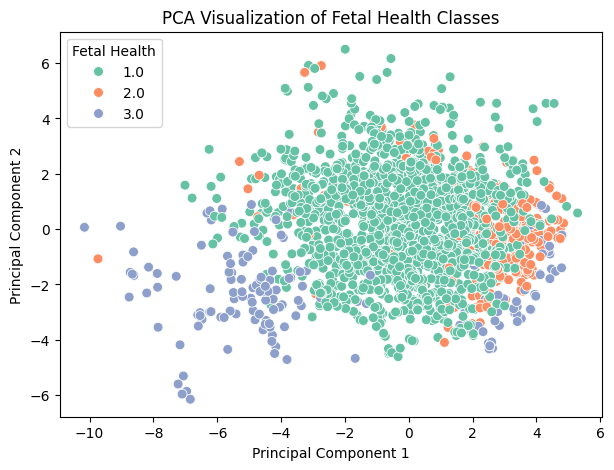

In [64]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set2', s=50)
plt.title("PCA Visualization of Fetal Health Classes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Fetal Health")
plt.show()


In [67]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.2 MB/s eta 0:00:00


In [70]:
# === SECTION 7: ANN Tuning with Optuna ===
import optuna
from sklearn.metrics import f1_score
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_ann_model(dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def objective(trial):
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    model = create_ann_model(dropout_rate, learning_rate)
    history = model.fit(X_train, y_train_cat, epochs=20, batch_size=batch_size,
                        validation_data=(X_test, y_test_cat), class_weight=class_weight_dict,
                        verbose=0)
    score = model.evaluate(X_test, y_test_cat, verbose=0)
    return score[1]  # accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("\nBest ANN parameters from Optuna:", study.best_params)


[I 2025-04-10 17:53:40,240] A new study created in memory with name: no-name-33ec6068-fec8-47aa-a415-539eadedbbb1
[I 2025-04-10 17:53:46,767] Trial 0 finished with value: 0.834515392780304 and parameters: {'dropout_rate': 0.4189577249829799, 'learning_rate': 0.0001800045931699641, 'batch_size': 32}. Best is trial 0 with value: 0.834515392780304.
[I 2025-04-10 17:53:51,329] Trial 1 finished with value: 0.8368794322013855 and parameters: {'dropout_rate': 0.3703502877319973, 'learning_rate': 0.0007030918460078883, 'batch_size': 64}. Best is trial 1 with value: 0.8368794322013855.
[I 2025-04-10 17:53:55,624] Trial 2 finished with value: 0.8250591158866882 and parameters: {'dropout_rate': 0.3363099947650555, 'learning_rate': 0.00012600899974963, 'batch_size': 64}. Best is trial 1 with value: 0.8368794322013855.
[I 2025-04-10 17:54:00,640] Trial 3 finished with value: 0.8439716100692749 and parameters: {'dropout_rate': 0.315642174915285, 'learning_rate': 0.0007214800242915894, 'batch_size': 


Best ANN parameters from Optuna: {'dropout_rate': 0.276169165284038, 'learning_rate': 0.0023111983530966747, 'batch_size': 16}


<ipython-input-71-771a5c9d1e72>:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


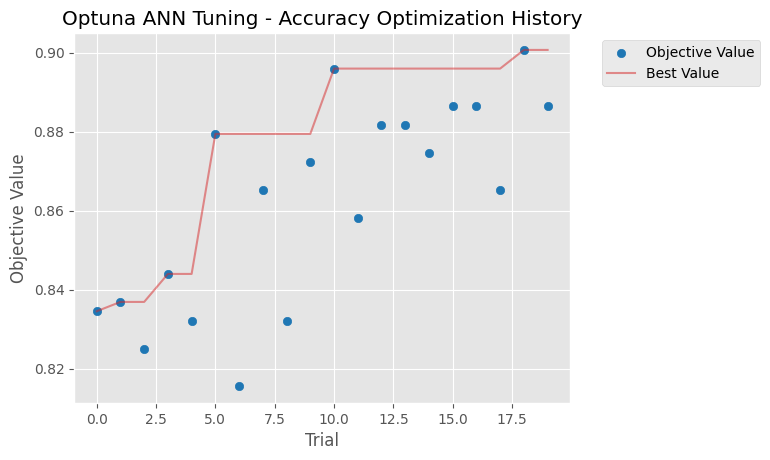

In [71]:
# === SECTION 8: Visualize Optuna Tuning History ===
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optuna ANN Tuning - Accuracy Optimization History")
plt.grid(True)
plt.show()

In [73]:
# === SECTION 9: Retrain Final ANN with Best Optuna Parameters ===

# Extract best parameters
best = study.best_params
dropout_rate = best['dropout_rate']
learning_rate = best['learning_rate']
batch_size = best['batch_size']

# Create and train the best ANN model
final_ann = create_ann_model(dropout_rate=dropout_rate, learning_rate=learning_rate)
final_ann.fit(X_train, y_train_cat,
              validation_data=(X_test, y_test_cat),
              epochs=50,
              batch_size=batch_size,
              class_weight=class_weight_dict,
              verbose=1)

# Predict and evaluate
y_final_pred = np.argmax(final_ann.predict(X_test), axis=1) + 1

print("\nFinal ANN (Optuna Tuned) Classification Report:")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_final_pred))


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7139 - loss: 0.7468 - val_accuracy: 0.8345 - val_loss: 0.4354
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.2800 - val_accuracy: 0.8463 - val_loss: 0.3559
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8434 - loss: 0.2462 - val_accuracy: 0.8322 - val_loss: 0.3645
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8324 - loss: 0.2570 - val_accuracy: 0.8322 - val_loss: 0.3681
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8504 - loss: 0.2129 - val_accuracy: 0.8511 - val_loss: 0.3133
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8544 - loss: 0.2249 - val_accuracy: 0.8511 - val_loss: 0.3358
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8695 - loss: 0.1999 - val_accuracy: 0.8463 - val_loss: 0.3235
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8544 - loss: 0.2132 - val_accuracy: 0.8676 - val_

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6152 - loss: 0.8599 - val_accuracy: 0.8298 - val_loss: 0.4689
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8006 - loss: 0.5141 - val_accuracy: 0.8463 - val_loss: 0.4085
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.4341 - val_accuracy: 0.8463 - val_loss: 0.3701
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8376 - loss: 0.4154 - val_accuracy: 0.8534 - val_loss: 0.3723
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8583 - loss: 0.3626 - val_accuracy: 0.8582 - val_loss: 0.3285
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8636 - loss: 0.3668 - val_accuracy: 0.8582 - val_loss: 0.3297
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8804 - loss: 0.3416 - val_accuracy: 0.8747 - val_loss: 0.3074
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8833 - loss: 0.3179 - val_accuracy: 0.8629 - val_

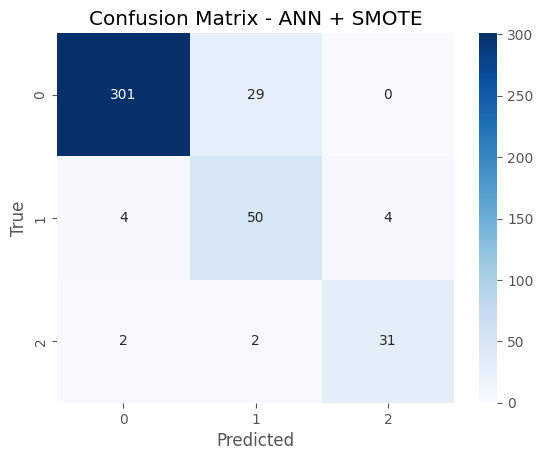

In [74]:
# === SECTION 4: SMOTE Comparison ANN===
X_sm, y_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)
y_sm_cat = to_categorical(y_sm - 1)

ann_smote = Sequential([
    Dense(64, activation='relu', input_shape=(X_sm.shape[1],)),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
ann_smote.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
ann_smote.fit(X_sm, y_sm_cat, validation_data=(X_test, y_test_cat),
              epochs=50, batch_size=32, verbose=1)

y_pred_ann_smote = np.argmax(ann_smote.predict(X_test), axis=1) + 1
evaluate_model("ANN + SMOTE", y_test, y_pred_ann_smote)